<img src="https://datascientest.fr/train/assets/logo_datascientest.png" style="height:150px"> 
<hr style="border-width:2px;border-color:##75DFC1">
<center> <h1> Projet COVID </h1> </center> <br>
<center> <h2> Tentative de Segmentation</h2> </center> <br>
<hr style="border-width:2px;border-color:##75DFC1">

Les images covid comportent des annotations qui peuvent biaiser les modèles de classification. Vu que seuls les poumons jouent un rôle dans la détection du covid, nous allons donc essayer de les segmenter.
<hr style="border-width:2px;border-color:##75DFC1">

>Utilisation de la librairie OpenCV

In [ ]:
# ! pip install opencv-python

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import cv2

os.chdir('COVID-19 Radiography Database')

df = pd.read_csv('img_metadata.csv')

In [5]:
df.head()

,path,Class,height,width,channel,B&W,luminosite
0,COVID/COVID (934).png,covid,331.0,331.0,3.0,True,106.488376
1,COVID/COVID (296).png,covid,256.0,256.0,3.0,True,119.666504
2,COVID/COVID (74).png,covid,256.0,256.0,3.0,True,153.078995
3,COVID/COVID (261).png,covid,256.0,256.0,3.0,True,186.787781
4,COVID/COVID (978).png,covid,331.0,331.0,3.0,True,159.006818


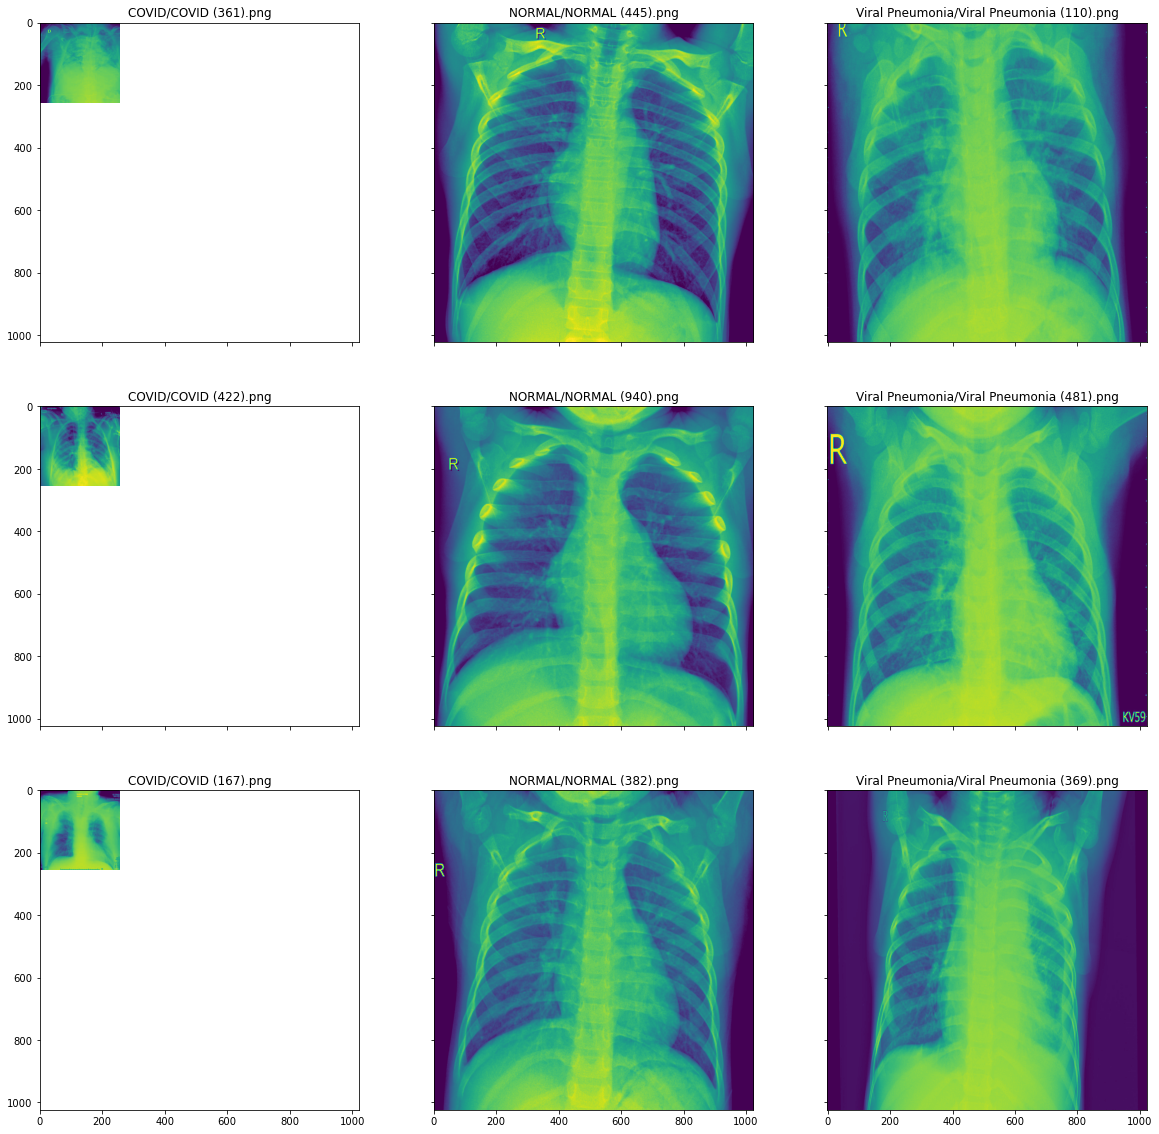

In [7]:
from random import choice

img_covid = df.loc[df.Class=='covid', 'path']
img_normal = df.loc[df.Class=='normal', 'path']
img_pneumo = df.loc[df.Class=='pneumo', 'path']


fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharex = True, sharey = True)

for i in range(len(axes)):
    for j, imgs in enumerate((img_covid, img_normal, img_pneumo)):
        image_name = choice(imgs.tolist())
        axes[i, j].set_title(image_name)
        scan = plt.imread(image_name)
        axes[i, j].imshow(scan);
        

In [112]:
# image_name = choice(img_normal.tolist())
# print(image_name)

NORMAL/NORMAL (493).png


In [2]:
image_name = 'NORMAL/NORMAL (493).png'

Image shape is: (1024, 1024)


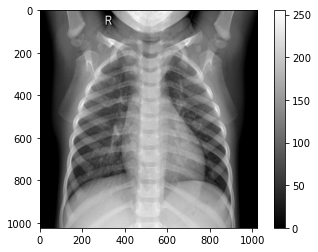

In [3]:
img = cv2.imread(image_name,0)
print('Image shape is:', img.shape)

plt.imshow(img,cmap='gray')
plt.colorbar();

Si l'image n'est pas droite, ça va poser problème vu qu'on a besoin de l'axe de symétrie

In [114]:
# def rotate_image(image, angle):
#   image_center = tuple(np.array(image.shape[1::-1]) / 2)
#   rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
#   result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
#   return result
# img_rot = rotate_image(img, -7)
# plt.imshow(img_rot,cmap='gray');

In [ ]:
# img = img_rot

On veut séparer l'image en deux au niveau de la colonne vertébrale

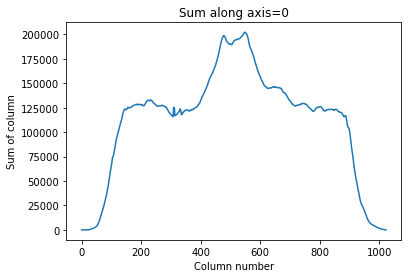

In [4]:
def eraseMax(img,eraseLineCenter=0,eraseLineWidth=30,draw=False):
    height, width = img.shape
    eraseLineWidth = int(height*30/512)
    sumpix0=np.sum(img,0)
    if draw:
        plt.plot(sumpix0)
        plt.title('Sum along axis=0')
        plt.xlabel('Column number')
        plt.ylabel('Sum of column')
    max_r2=np.int_(len(sumpix0)/3)+np.argmax(sumpix0[np.int_(len(sumpix0)/3):np.int_(len(sumpix0)*2/3)])
    cv2.line(img,(max_r2+eraseLineCenter,0),(max_r2+eraseLineCenter,height),0,eraseLineWidth)
    return img

img_erased = eraseMax(img,draw=True)

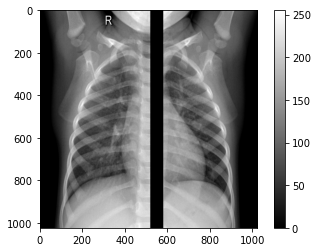

In [5]:
plt.imshow(img_erased,cmap='gray')
plt.colorbar();

Normalisons les images et ajoutons du détail grâce à un filtre CLAHE

-- https://imagej.net/Enhance_Local_Contrast_(CLAHE) --


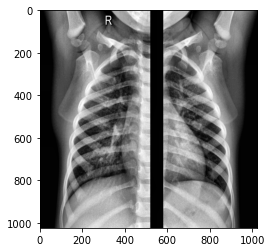

In [6]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img_erased)   
plt.imshow(img_clahe,cmap='gray');

https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html

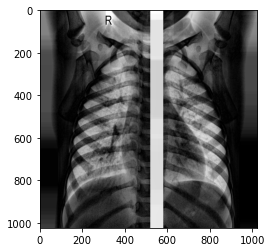

In [7]:
ker = 169
kernel = np.ones((ker,ker),np.uint8)
blackhat = cv2.morphologyEx(img_clahe, cv2.MORPH_BLACKHAT, kernel)    
plt.imshow(blackhat,cmap='gray');

On applique un seuil pour segmenter

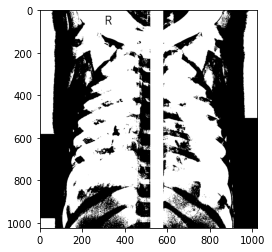

In [8]:
threshold = 45
ret, thresh = cv2.threshold(blackhat, threshold, 255, 0)
plt.imshow(thresh,cmap='gray');

On fait ensuite une détection de coins sur l'image de départ. Les nombreux petits détails des poumons se détectent bien comme des coins

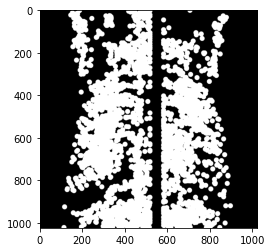

In [9]:
def get_cmask(img, maxCorners=3800, qualityLevel=0.001, minDistance=1,Cradius=6):
    height, width = img.shape
    Cradius = int(height*6/512)
    corners = cv2.goodFeaturesToTrack(img, maxCorners, qualityLevel, minDistance)
    corners = np.int0(corners)
    cmask = np.zeros(img.shape)
    for corner in corners:
        x,y = corner.ravel()
        cv2.circle(cmask,(x,y),Cradius,1,-1)
    return cmask

cmask = get_cmask(img_clahe)
plt.imshow(cmask,cmap='gray');

On a donc les poumons sans l'arrière plan. On multiplie ensuite les deux résultats (seuillage x coins)

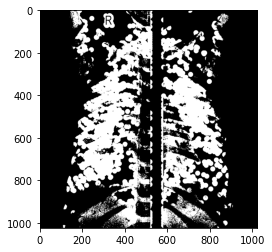

In [10]:
mask = np.multiply(cmask,thresh).astype('uint8')
plt.imshow(mask,cmap='gray');

On applique un filtre médian pour réduire le bruit

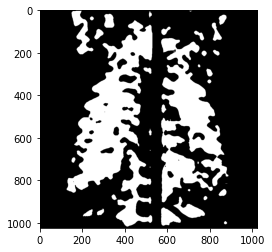

In [11]:
median = cv2.medianBlur(mask,23) 
plt.imshow(median,cmap='gray');

On applique une recherche de contours pour ne garder que les 2 plus importants : les poumons

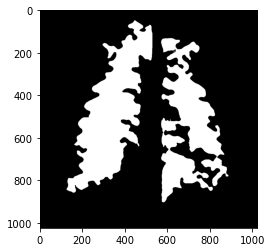

In [12]:
def contourMask(image):
    contours,hierc = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
    area = np.zeros(len(contours))
    for j in range(len(contours)):
        cnt = contours[j]
        area[j] = cv2.contourArea(cnt)
    mask = np.zeros(image.shape)
    cv2.drawContours(mask, contours, np.argmax(area), (255), -1)#draw largest contour-usually right lung   
    temp = np.copy(area[np.argmax(area)])
    area[np.argmax(area)]=0
    if area[np.argmax(area)] > temp/10:#make sure 2nd largest contour is also lung, not 2 lungs connected
        cv2.drawContours(mask, contours, np.argmax(area), (255), -1)#draw second largest contour  
    contours.clear() 
    return mask

contour_mask = contourMask(median).astype('uint8')
plt.imshow(contour_mask,cmap='gray');

On applique une dilatation pour être sûr d'avoir les poumons en entier, quitte à "dépasser" un peu

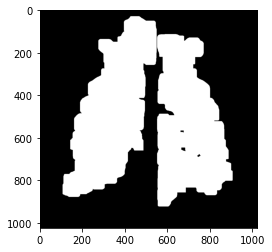

In [13]:
ker = 40
kernel = np.ones((ker,ker),np.uint8)
dilatation = cv2.dilate(contour_mask,kernel,iterations = 1)
plt.imshow(dilatation,cmap='gray');

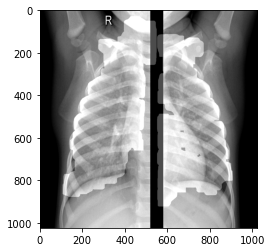

In [14]:
alpha = 0.3
output = cv2.addWeighted(dilatation, alpha, img, 1, 0)
plt.imshow(output,cmap='gray');

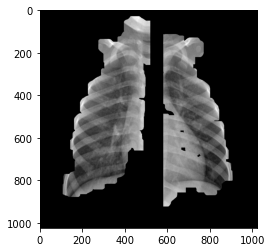

In [15]:
res = cv2.bitwise_and(img,img,mask = dilatation)
plt.imshow(res,cmap='gray');